In [478]:
import pandas as pd
import glob
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from Bio import Entrez
from scipy.cluster.hierarchy import dendrogram, linkage
import subprocess
import multiprocessing
import plotly.express as px

In [765]:
dataset = 'test'
path = f'DATA/{dataset}/'

In [766]:
data = pd.read_table(f'DATA/{dataset}/result_coverage_table.tsv', index_col=0, converters={'fragments_coverage': pd.eval})

In [767]:
data

,Species,Virus name(s),Host source,coverage,max_coverage,min_coverage,quality,len,fragments_coverage,Realm,Kingdom,Subkingdom,Phylum,Subphylum,Class,Order,Family,Genus,Species.1,Virus GENBANK accession
0,Miniopterus bat coronavirus 1,miniopterus bat coronavirus 1,vertebrates,100,100,100,0.600000,28325,[100],Riboviria,Orthornavirae,NaN,Pisuviricota,NaN,Pisoniviricetes,Nidovirales,Coronaviridae,Alphacoronavirus,Miniopterus bat coronavirus 1,EU420138
1,Lophivirus Xv2,Xanthomonas phage phiXv2,bacteria,72,72,72,0.590196,6563,[72],Monodnaviria,Loebvirae,NaN,Hofneiviricota,NaN,Faserviricetes,Tubulavirales,Inoviridae,Lophivirus,Lophivirus Xv2,MH206183
2,Malvastrum leaf curl deltasatellite,Malvastrum leaf curl deltasatellite,plants,7,7,7,0.400000,672,[7],NaN,NaN,NaN,NaN,NaN,NaN,NaN,Tolecusatellitidae,Deltasatellite,Malvastrum leaf curl deltasatellite,KF433066
3,Bat associated circovirus 13,bat circovirus,vertebrates,3,3,3,0.000000,2062,[3],Monodnaviria,Shotokuvirae,NaN,Cressdnaviricota,NaN,Arfiviricetes,Cirlivirales,Circoviridae,Circovirus,Bat associated circovirus 13,MN928506
4,Andrographis yellow vein leaf curl betasatellite,Andrographis yellow vein leaf curl betasatellite,plants,3,3,3,0.348000,1378,[3],NaN,NaN,NaN,NaN,NaN,NaN,NaN,Tolecusatellitidae,Betasatellite,Andrographis yellow vein leaf curl betasatellite,KC967282
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10153,Foxunavirus fox2,Xanthomonas phage FoX2,bacteria,0,0,0,0.000000,44085,[0],Duplodnaviria,Heunggongvirae,NaN,Uroviricota,NaN,Caudoviricetes,NaN,NaN,Foxunavirus,Foxunavirus fox2,MT161382
10154,Foxunavirus fox3,Xanthomonas phage FoX3,bacteria,0,0,0,0.000000,44152,[0],Duplodnaviria,Heunggongvirae,NaN,Uroviricota,NaN,Caudoviricetes,NaN,NaN,Foxunavirus,Foxunavirus fox3,MT161383
10155,Foxunavirus fox5,Xanthomonas phage FoX5,bacteria,0,0,0,0.000000,43871,[0],Duplodnaviria,Heunggongvirae,NaN,Uroviricota,NaN,Caudoviricetes,NaN,NaN,Foxunavirus,Foxunavirus fox5,MT161384
10156,Fragaria chiloensis latent virus,Fragaria chiloensis latent virus,plants,0,0,0,0.000000,8482,"[0, 0, 0]",Riboviria,Orthornavirae,NaN,Kitrinoviricota,NaN,Alsuviricetes,Martellivirales,Bromoviridae,Ilarvirus,Fragaria chiloensis latent virus,RNA1: AY682102; RNA2: AY707771; RNA3: AY707772


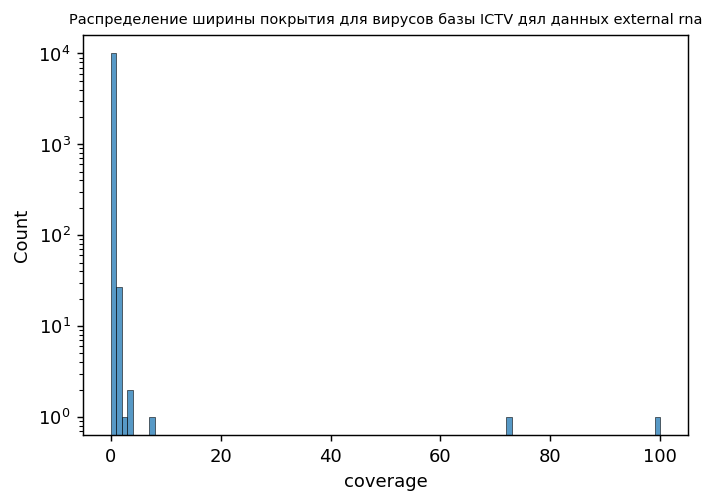

In [768]:
plt.figure(figsize=(6, 4), dpi=130)
plt.title('Распределение ширины покрытия для вирусов базы ICTV дял данных external rna', fontdict={'size':8})
sns.histplot(data.coverage, bins=100)
plt.yscale('log')

In [769]:
plt.figure(figsize=(3, 8), dpi=130)
#plt.title(f'20 вирусов из базы ICTV с наилучшим покрытием на данных {dataset}')
px.bar(data=data.sort_values('coverage', ascending=False)[:20], x='max_coverage', y='Virus name(s)')
#plt.xlabel('Max coverage')
#plt.ylabel('Virus names sorted by mean coverage')

TypeError: bar() got an unexpected keyword argument 'data'

<Figure size 390x1040 with 0 Axes>

In [770]:
ictv_coverages = glob.glob(f'{path}/ictv_coverage/*.csv')

In [771]:
common_table = (pd.DataFrame(pd.read_csv(ictv_coverages[0], index_col=0).coverage).
                rename(columns={'coverage':os.path.splitext(os.path.basename(ictv_coverages[0]))[0]}))
for ictv_coverage in ictv_coverages[1:]:
    name = os.path.splitext(os.path.basename(ictv_coverage))[0]
    common_table[name] = pd.DataFrame(pd.read_csv(ictv_coverage, index_col=0).coverage)

In [772]:
barplot_table = pd.DataFrame(common_table.loc[common_table.mean(axis=1).sort_values(ascending=False).index].max(axis=1))
barplot_table.columns = ['max_coverage']
barplot_table['mean_coverage'] = common_table.loc[common_table.mean(axis=1).sort_values(ascending=False).index].mean(axis=1)
barplot_table['mean_coverage'] = barplot_table['mean_coverage'].astype('float')
barplot_table = barplot_table.reset_index()

plt.figure(figsize=(3, 8), dpi=130)
px.bar(x=barplot_table[:40]['max_coverage'], y=barplot_table[:40]['Species'], width=700, height=700, )
#plt.title(f'20 вирусов из базы ICTV с наилучшим покрытием \n на данных {dataset}')
#plt.xlabel('Max coverage')
#plt.ylabel('Virus names sorted by mean coverage')

In [774]:
means = common_table.mean(axis=1)
# sort the rows by the median values
sorted_df = common_table.iloc[means.argsort()[::-1]]

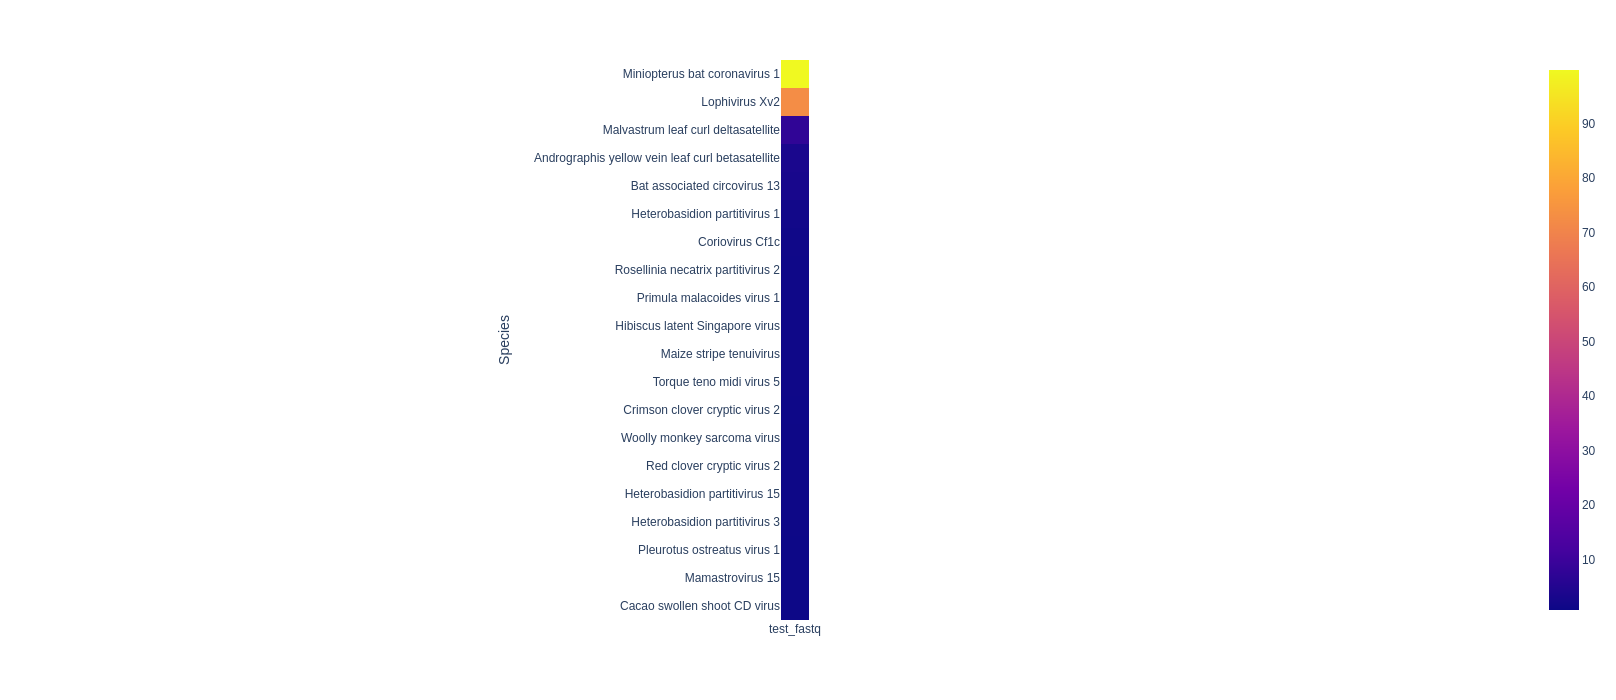

In [775]:
#plt.figure(figsize=(16, 8), dpi=130)
px.imshow(sorted_df[:20]*100, width=700, height=700)
#plt.title(f'Тепловая карта покрытия на ICTV на данных {dataset}')
#plt.ylabel('Species sorted by max coverage')

In [ ]:
data = sorted_df[:40].T

Z = linkage(data)

# sort rows of the table based on the clustering
sorted_data = data.iloc[Z[:, 0], :].T

IndexError: positional indexers are out-of-bounds

In [600]:
sorted_df[:40].T

Species,Cucumber green mottle mosaic virus,Lambdavirus lambda,Hedgehog coronavirus 1,Carrot cryptic virus,Unuamitovirus alar1,Tomato mosaic virus,Escherichia virus DE3,Lambdavirus lvO276,Lambdavirus HK630,Deformed wing virus,...,Duamitovirus scni2,Nesevirus ev243,Magoulivirus zetaplasmoparae,Pseudotevenvirus RB43,Finkel-Biskis-Jinkins murine sarcoma virus,Woolly monkey sarcoma virus,Wasabi mottle virus,Alxa mammarenavirus,Phietavirus pv37,Radostvirus ev099
F350009910_1_L02_63,0.060243,0.309616,0.980629,0.005071,0.078212,0.069090,0.172044,0.223236,0.231026,0.001874,...,0.022842,0.041198,0.178433,0.215003,0.072947,0.011248,0.012702,0.179949,0.009157,0.014018
F350009910_1_L02_60,0.379359,0.949837,0.074599,0.000000,0.115722,0.009087,0.787420,0.787843,0.786090,0.005720,...,0.000000,0.155904,0.000000,0.002183,0.163212,0.018515,0.035090,0.003777,0.008974,0.056878
F350010037_L12_43,0.030355,0.000000,0.000697,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.066387,0.010901,0.000000,0.000000,0.000000,0.000000
F350009910_1_L01_14,0.004670,0.000412,0.000630,0.000000,0.000000,0.003133,0.000000,0.000477,0.000467,0.000000,...,0.000000,0.000000,0.000000,0.000216,0.063500,0.009690,0.000000,0.001888,0.000870,0.000402
F350010037_L12_2,0.153487,0.000000,0.000000,0.000000,0.622506,0.000000,0.000000,0.002383,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.101286,0.000000,0.126866,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
F350009910_1_L02_undecoded,0.029421,0.121129,0.973199,0.000000,0.276137,0.034467,0.056308,0.096333,0.062221,0.000000,...,0.000000,0.028161,0.000000,0.014033,0.064025,0.011248,0.029692,0.107913,0.008081,0.000000
F350009910_1_L01_41,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
F350009910_1_L02_52,0.000000,0.000000,0.041694,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
F350009910_1_L01_104,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.002349,0.000000,0.000122,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Text(92.13888888888886, 0.5, 'Species sorted by max coverage')

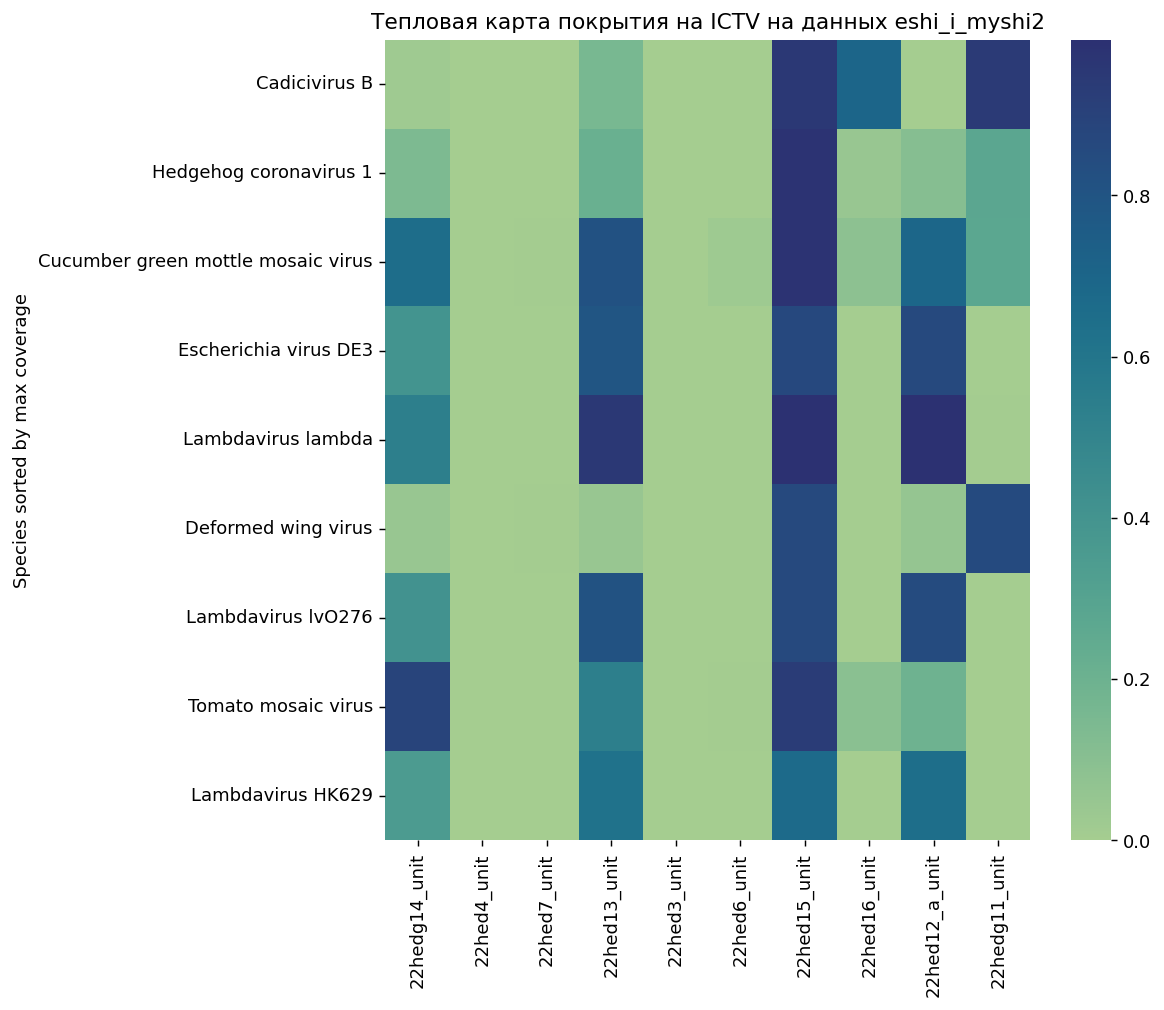

In [565]:
plt.figure(figsize=(8, 8), dpi=130)
sns.heatmap(sorted_data, cmap="crest")
plt.title(f'Тепловая карта покрытия на ICTV на данных {dataset}')
plt.ylabel('Species sorted by max coverage')

In [733]:
common_table

,bat22-2015,bat33-2015,Bats2015_16_S1,Bats2015_30_S6,Bats2015_21_S4,Bats2015_31_S7,Bats2015_19_S2,Bats2015_27_S5,bat2-2015,bat6-2015,Bats2015_20_S3,bat23-2015
Species,,,,,,,,,,,,
Sinsheimervirus phiX174,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Middle East respiratory syndrome-related coronavirus,0.341446,0.134367,0.016402,0.007006,0.166506,0.029516,0.025698,0.060759,0.012617,0.011056,0.021282,0.018261
Murine leukemia virus,0.283245,0.264762,0.244239,0.255161,0.247000,0.264042,0.265362,0.262842,0.248920,0.244239,0.253481,0.249040
Heterocapsa circularisquama DNA virus 01,0.207931,0.290000,0.080345,0.151897,0.054138,0.261207,0.215345,0.410172,0.148448,0.128103,0.126034,0.208793
Amsacta moorei entomopoxvirus,0.201625,0.198161,0.076440,0.140870,0.054365,0.229621,0.209207,0.239191,0.135246,0.116781,0.133671,0.215481
...,...,...,...,...,...,...,...,...,...,...,...,...
Alehxovirus humivivens,0.000000,0.005618,0.000000,0.005618,0.010166,0.039058,0.015249,0.015249,0.015784,0.000000,0.000000,0.000000
Gyrovirus galga2,0.000000,0.000000,0.000000,0.000000,0.000000,0.007790,0.008200,0.000000,0.038950,0.000000,0.016400,0.008200
Gemycircularvirus austro6,0.000000,0.000000,0.025327,0.008297,0.017467,0.024891,0.034061,0.008734,0.016594,0.000000,0.000000,0.025327


In [735]:
barplot_table.mean_coverage

0        1.000000
1        0.256861
2        0.218206
3        0.190201
4        0.177141
           ...   
10153    0.000000
10154    0.000000
10155    0.000000
10156    0.000000
10157    0.000000
Name: mean_coverage, Length: 10158, dtype: float64